# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

# Processing Base Billings Data

In [2]:
df = pd.read_excel('../data/Data_2019_P06/base_billings.xlsx', sheet_name='bill_DC')

In [3]:
df.sample(10)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
5896,CHF,Document Cloud,NaN,2017-01,1Y,A,NaN,DEFERRED,1,333.64
5814,CHF,Document Cloud,NaN,2016-05,1Y,A,NaN,DEFERRED,1,79.00
29739,USD,Experience Cloud,1TME,2016-03,OUNIV,F,NaN,DEFERRED,0,-173551.00
1025,AUD,Document Cloud,NaN,2015-10,1Y,A,NaN,DEFERRED,12,354618.40
33190,USD,Print & Publishing,NaN,2016-08,1Y,D,YQ,DEFERRED,12,180.00
15860,GBP,Document Cloud,NaN,2018-06,1Y,D,YQ,DEFERRED,0,4922.90
13642,EUR,Print & Publishing,NaN,2016-01,1Y,D,YQ,DEFERRED,12,10454.24
17784,GBP,Other Solutions,ONGO,2015-11,OUNIV,A,NaN,DEFERRED,0,2504.00
15005,GBP,Creative,NaN,2018-08,MTHLY,D,Y3,DEFERRED,1,556826.46
20951,JPY,Experience Cloud,ONGO,2017-02,NaN,A,NaN,DEFERRED,0,10250000.00


## Changing the column names early since they are inconsistent across other reports

In [4]:
df.columns

Index(['Document Currency', 'Enterprise Bu', 'Frequency',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Revenue Recognition Category New', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales Doc Currency'],
      dtype='object')

In [5]:
df.rename(index = str, columns = {'Document Currency': 'curr',
                                 'Enterprise Bu': 'BU',
                                 'Invoicing Fiscal Year-Period Desc': 'period',
                                 'Product Configtype ID': 'config',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales Doc Currency': 'amount'}, inplace=True)

In [6]:
df.columns

Index(['curr', 'BU', 'Frequency', 'period', 'config',
       'Revenue Recognition Category New', 'rebill_rule', 'Sales Type',
       'Subscription Term', 'amount'],
      dtype='object')

## Remove any currency that has  < 10 transactions. 


In [7]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()

In [8]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['curr'].isin(a)]

## Just keeping track of the currencies we removed in our model_dict data structure

In [9]:
remove_these = vc.values <= 10
model_dict = {'curr_removed': list(vc[remove_these].index)}
model_dict

{'curr_removed': ['BMD', 'ILS', 'MXP', 'SAR', 'INR']}

## Removing any of the values that are zero

In [10]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  33945
This is the length of the dataframe after removing zeros:  31263


In [11]:
df.sample(10)

,curr,BU,Frequency,period,config,Revenue Recognition Category New,rebill_rule,Sales Type,Subscription Term,amount
17825,GBP,Other Solutions,ONGO,2017-12,OUNIV,A,NaN,DEFERRED,0,1.519400e+03
27908,USD,Document Cloud,NaN,2016-04,1Y,A,NaN,DEFERRED,12,3.235134e+06
27260,USD,Creative,ONGO,2018-09,NaN,D,NaN,DEFERRED,12,2.000711e+06
28519,USD,Document Cloud,NaN,2018-04,1Y,A,NaN,DEFERRED,0,8.400445e+05
19455,JPY,Creative,NaN,2018-03,1Y,D,NaN,DEFERRED,12,1.328428e+08
23238,NOK,Document Cloud,NaN,2019-06,NaN,D,YA,DEFERRED,12,4.117863e+05
18400,GBP,Print & Publishing,NaN,2018-12,MTHLY,D,Y3,DEFERRED,1,1.826000e+01
20446,JPY,Document Cloud,NaN,2018-12,1Y,D,YA,DEFERRED,12,3.131991e+07
5201,CAD,Print & Publishing,NaN,2019-04,1Y,D,YA,DEFERRED,12,4.728387e+04
25202,SEK,Experience Cloud,ACTL,2017-07,ONORE,NaN,NaN,RECOGNIZED,0,4.514711e+04


In [12]:
#df['curr'].value_counts()

## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [13]:
df['Sales Type'].value_counts()

DEFERRED       24902
RECOGNIZED      5355
PRO-SVC-INV      906
NON-REV          100
Name: Sales Type, dtype: int64

In [14]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  31263
Length of the dataframe after removing non-revenue billings:   31163


## Starting to group the revenue by period, industry, etc

Groupong the billings by the following categories
 - currency
 - period
 - sale type
 

DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 

In [15]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED']
svc = df[df['Sales Type']=='PRO-SVC-INV']
dfr = df[df['Sales Type']=='DEFERRED']

In [16]:
# Filter and group billings function will delete temporary datasets as completed
def filter_and_group(data2process, gblist, billings_type=None):
    """filter and group Base Billings Data"""
    
    #when a billings_type is supplied then filter, else just go to groupby below
    if billings_type:
        data2process = data2process[data2process['Revenue Recognition Category New']==billings_type]
    
    #groupby the columns passed in the function call then remove the subscription term column
    gb = data2process.groupby(gblist, as_index=False).sum()
    gb.drop(labels='Subscription Term', axis=1, inplace = True)
    return gb

In [17]:
gb_rec = filter_and_group( rec, ['curr', 'BU', 'period'])
gb_svc = filter_and_group( svc, ['curr', 'BU', 'period'])
gb_a = filter_and_group(dfr, ['curr', 'BU', 'period', 'config'],  'A')
gb_b = filter_and_group(dfr,['curr', 'BU', 'period'],  'B')
gb_d = filter_and_group(dfr,['curr', 'BU', 'period',
                     'rebill_rule'], 'D')

## NOW WORKING ON THE BILLINGS

### Recognized Revenue

In [18]:
#gb_rec.sample(10)

In [19]:
# testing groupby object
#gb_rec = rec.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [20]:
# the Subscription term hangs around. We are dropping that here
#gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [21]:
#gb_rec.sample(10)

In [22]:
#print(type(gb_rec))

### Service Billings

In [23]:
# testing groupby object
#gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [24]:
#gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
#gb_svc.head(5)

### NOW WORKING ON DEFERRED BILLINGS

Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [25]:
# filter out the type B first then do a group_by
#dfr_b = dfr[dfr['Revenue Recognition Category New']=='B']

In [26]:
#gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [27]:
#gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [28]:
#gb_b.head(10)

In [29]:
#print('length of deferred billings : ', len(dfr))
#print('length of the type B billings: ', len(dfr_b))

## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [30]:
# filtering just the type A billings
#dfr_a = dfr[dfr['Revenue Recognition Category New']=='A']

In [31]:
#gb_a = dfr_a.groupby(['curr', 'BU', 'period',
#                     'config'], as_index=False).sum()
#gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [32]:
gb_a.sample(10)

,curr,BU,period,config,amount
2815,NOK,Print & Publishing,2015-12,1Y,747.00
516,CAD,Creative,2017-04,1Y,509097.98
2256,JPY,Creative,2016-09,2Y,7326720.00
331,AUD,Experience Cloud,2018-08,1Y,439885.24
3134,USD,Creative,2016-02,1Y,29789894.21
2037,GBP,LiveCycle,2016-06,1Y,2722.87
3263,USD,Creative,2019-03,MTHLY,1473192.55
148,AUD,Document Cloud,2015-09,1Y,568379.64
1032,DKK,Document Cloud,2016-08,1Y,-8.67
342,AUD,Experience Cloud,2019-05,1Y,326535.36


In [33]:
gb_a['config'].value_counts()

1Y       1936
MTHLY     829
2Y        693
OUNIV     178
OCONS      62
3Y         58
ONORE      29
Name: config, dtype: int64

### Below is just a check to see how large the billing types are across all periods

In [34]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

,config,amount
0,1Y,7.195507e+10
1,2Y,2.080207e+08
2,3Y,1.560911e+08
3,MTHLY,-1.638659e+07
4,OCONS,2.883743e+07
5,ONORE,2.260631e+06
6,OUNIV,3.412069e+06


### These 'OCONS', 'ONORE' and 'OUNIV' data types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [35]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a['config'].isin(config_list)
sum(test1)

3516

In [36]:
test1 = gb_a[gb_a['config'].isin(config_list)]

## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [37]:
gb_a_1Y = test1[test1['config']=='1Y']
gb_a_2Y = test1[test1['config']=='2Y']
gb_a_3Y = test1[test1['config']=='3Y']
gb_a_1M = test1[test1['config']=='MTHLY']

In [38]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  829
this is the lenght of type A 1Y billings:  1936
this is the lenght of type A 2Y billings:  693
this is the lenght of type A 3Y billings:  58


## TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly [Y1, Y2, Y3, Y5]
 - Quarterly [YQ]
 - Every 4 months [YT]
 - Semi-annual [YH]
 - Annual [YA, YC]
 - Every 2 years - [Y4]
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [39]:
# for now just do a groupby on the type
# filtering just the type A billings
#dfr_d = dfr[dfr['Revenue Recognition Category New']=='D']

In [40]:
#gb_d = dfr_d.groupby(['curr', 'BU', 'period',
#                     'rebill_rule'], as_index=False).sum()
#gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [50]:
gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_qtrly = gb_d[gb_d['rebill_rule']=='YQ']
gb_d_four_mths = gb_d[gb_d['rebill_rule']=='YT']
gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']
gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']

# these two have multiple rebill rules. We need to then group them by ['curr', 'BU', 'period'] 
# to avoid repeated lines when merged later
gb_d_mthly_pre = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_mthly = gb_d_mthly_pre.groupby(['curr', 'BU', 'period']).sum()
gb_d_annual_pre = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC'])]
gb_d_annual = gb_d_annual_pre.groupby(['curr', 'BU', 'period']).sum()


In [51]:
# Need to sum the groups that have multiple rebill_rules or we end up with a duplicate when all of the items are merged
#gb_d_mthly.head(10)
#gb_d_mthly['rebill_rule'].value_counts()
#the_sum = gb_d_mthly['amount'].sum()
#print(the_sum)
#test_gb_d_mthly = gb_d_mthly.groupby(['curr', 'BU', 'period']).sum()
#new_sum = test_gb_d_mthly['amount'].sum()
#print(new_sum)

In [52]:
gb_d_mthly.head(10)

amount
curr BU             period             
ARS  Creative       2019-03   419565.00
                    2019-04  1894409.00
                    2019-05  3205378.29
                    2019-06  5731933.57
     Document Cloud 2019-04    16748.00
                    2019-05    31863.00
                    2019-06    68726.00
AUD  Creative       2015-06  4995447.52
                    2015-07  4119366.88
                    2015-08  4368698.07

In [44]:
#gb_d['rebill_rule'].value_counts()

In [45]:
#gb_d['curr'].value_counts()

### Note: There is one type D billings that is listed as 'BT' I don't know what this means, but it was a $180 EUR payment from January 2017, so we will ignore

In [54]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))

Length of monthly 1721
Length of quarterly 571
Length of four months 8
Length of semi ann 255
Length of annual 1799
Length of two years 27


In [55]:
what_is_BT = gb_d[gb_d['rebill_rule']=='YT']
what_is_BT.head(10)

,curr,BU,period,rebill_rule,amount
4417,USD,Experience Cloud,2015-06,YT,11666.60
4431,USD,Experience Cloud,2015-08,YT,549861.11
4444,USD,Experience Cloud,2015-10,YT,11666.60
4464,USD,Experience Cloud,2016-01,YT,612916.60
4469,USD,Experience Cloud,2016-02,YT,-601250.00
4529,USD,Experience Cloud,2016-12,YT,13440.00
4553,USD,Experience Cloud,2017-04,YT,13440.00
4577,USD,Experience Cloud,2017-08,YT,13440.00


## Note: There are only 8 payments (back from 2017) that paid on a 4 month basis. 
We will ignore these as well.

## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [56]:
# We need to do it this way when we get to a .py file!
list_df = [gb_rec, gb_svc, gb_b,
        gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
        gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
    'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
    'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d']


In [58]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'amount': new_column}, inplace=True)
        
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [59]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        #print("This is the df: ", df.head())
        print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0]
            df_merged.rename(index=str, columns={'amount': list_columns[i]}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [60]:
df = merge_all_dataframes(list_df, list_columns)

This is i: 0
referencing the column:  recognized
This is i: 1
referencing the column:  service
This is i: 2
referencing the column:  deferred_B
This is i: 3
referencing the column:  deferred_1M_a
This is i: 4
referencing the column:  deferred_1Y_a
This is i: 5
referencing the column:  deferred_2Y_a
This is i: 6
referencing the column:  deferred_3Y_a
This is i: 7
referencing the column:  deferred_1M_d
This is i: 8
referencing the column:  deferred_3M_d
This is i: 9
referencing the column:  deferred_6M_d
This is i: 10
referencing the column:  deferred_1Y_d
This is i: 11
referencing the column:  deferred_2Y_d


In [63]:
df.head(10)

,curr,BU,period,recognized,service,deferred_B,deferred_1M_a,deferred_1Y_a,deferred_2Y_a,deferred_3Y_a,deferred_1M_d,deferred_3M_d,deferred_6M_d,deferred_1Y_d,deferred_2Y_d
0,AUD,Creative,2015-06,490156.86,NaN,NaN,-2758.57,2601332.25,26443.20,NaN,4995447.52,NaN,NaN,3226774.85,NaN
1,AUD,Creative,2015-07,235045.62,NaN,NaN,-3380.48,2669684.62,10399.50,NaN,4119366.88,NaN,NaN,2341510.15,NaN
2,AUD,Creative,2015-08,284334.70,NaN,NaN,-2883.40,2661794.06,2316.62,NaN,4368698.07,NaN,NaN,1327729.48,NaN
3,AUD,Creative,2015-09,369648.88,NaN,NaN,-4480.56,3646842.53,11534.00,NaN,5669560.02,NaN,NaN,2194183.65,NaN
4,AUD,Creative,2015-10,287292.48,NaN,NaN,-3188.41,2547182.54,11802.30,NaN,4649336.15,NaN,NaN,1897555.57,NaN
5,AUD,Creative,2015-11,361723.22,NaN,NaN,-5882.06,1731502.65,32399.50,NaN,5083456.05,NaN,NaN,1750356.35,NaN
6,AUD,Creative,2015-12,276178.28,NaN,NaN,-3511.62,4852252.69,20414.00,NaN,6504775.23,NaN,NaN,6837563.10,NaN
7,AUD,Creative,2016-01,270306.21,NaN,NaN,-3691.27,2153684.38,37020.00,NaN,6706754.92,NaN,NaN,1568587.72,NaN
8,AUD,Creative,2016-02,116996.45,NaN,NaN,-4004.69,1599637.04,6992.00,NaN,5467807.06,NaN,NaN,2558415.43,NaN
9,AUD,Creative,2016-03,235382.84,NaN,NaN,-8805.69,2615203.82,36388.00,NaN,7499720.70,NaN,NaN,3129145.48,NaN


In [ ]:
#df['curr'].value_counts()

In [64]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # Monthly
    df['deferred_1M'] = df['deferred_1M_a']+df['deferred_1M_d']
    df.drop(labels=['deferred_1M_a', 'deferred_1M_d'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y'] = df['deferred_1Y_a']+df['deferred_1Y_d']
    df.drop(labels=['deferred_1Y_a', 'deferred_1Y_d'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y'] = df['deferred_2Y_a']+df['deferred_2Y_d']
    df.drop(labels=['deferred_2Y_a', 'deferred_2Y_d'], axis=1, inplace=True)
    
    # renaming 3Y, 3M and 6M
    df.rename(index=str, columns = {'deferred_3Y_a':'deferred_3Y', 'deferred_3M_d':'deferred_3M', 
                               'deferred_6M_d': 'deferred_6M'}, inplace=True)

    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

In [65]:
df = clean_df_columns(df)

In [66]:
df.sample(10)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_3M,deferred_6M,deferred_1M,deferred_1Y,deferred_2Y
2741,CAD,Document Cloud,2018-02,0.00,0.00,0.0,0.0,0.00,0.0,0.00,281116.80,0.00
1876,NZD,Experience Cloud,2018-10,5238.03,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
70,AUD,Document Cloud,2017-03,535483.00,0.00,0.0,0.0,0.00,0.0,329392.24,2452551.95,9466.00
1039,EUR,Print & Publishing,2015-06,767648.90,0.00,0.0,0.0,10454.24,0.0,37899.61,1255577.91,23007.00
285,CAD,Experience Cloud,2016-07,132845.02,366361.44,31500.0,0.0,143462.85,12500.0,7500.00,916769.58,0.00
2150,SEK,Print & Publishing,2018-06,32039.00,0.00,0.0,0.0,0.00,0.0,42780.00,430.50,0.00
130,AUD,Experience Cloud,2018-02,257812.08,768459.38,45802.5,0.0,905643.36,124906.0,14775.00,2627836.85,0.00
2257,USD,Document Cloud,2019-05,12246535.62,0.00,15750.0,73143.0,26119.89,0.0,3871936.60,27859091.22,156502.00
46,AUD,Creative,2019-04,121348.81,0.00,0.0,0.0,0.00,0.0,15074722.86,8551628.12,6347.31
38,AUD,Creative,2018-08,203324.92,0.00,0.0,0.0,0.00,0.0,13597519.97,7679950.39,1103.88


In [ ]:
#df.curr.value_counts()

In [67]:
# Make this a function to be cleaned up somehow
del dfr
#del dfr_a
#del dfr_b
#del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_four_mths, gb_d_qtrly, gb_d_semi_ann


# Now working on the ZCC billings

These billings are type D billings that did not populate the rebill_rule field of the database.

They have a 'sales document type' = 'ZCC"

The billings themselves are being created from a tableau report that looks for additions to the deferred revenue waterfall based on billings of type D and have a sales document type of ZCC

In [68]:
df.sample(10)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_3M,deferred_6M,deferred_1M,deferred_1Y,deferred_2Y
1307,GBP,Other Solutions,2018-04,-694.07,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
278,CAD,Experience Cloud,2015-12,174714.39,494318.35,185596.00,0.0,187314.59,0.00,7500.00,367335.46,0.00
2707,PEN,Document Cloud,2019-04,0.00,0.00,0.00,0.0,0.00,0.00,242.59,5435.54,0.00
176,AUD,LiveCycle,2017-11,4582.50,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
1755,NOK,Experience Cloud,2015-07,434990.23,22150.00,0.00,0.0,603765.00,0.00,0.00,0.00,0.00
2663,CLP,Document Cloud,2019-03,0.00,0.00,0.00,0.0,0.00,0.00,10200.00,16240.00,0.00
2627,NOK,Print & Publishing,2017-09,0.00,0.00,0.00,0.0,0.00,0.00,21728.00,4749.50,0.00
1028,EUR,Other Solutions,2018-08,-6762.97,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2161,USD,Creative,2015-06,31105538.88,179021.88,17700.16,0.0,714356.34,92888.32,54242904.27,82958733.45,132701.06
1261,GBP,LiveCycle,2017-08,1673.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00


# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)
2. Make a function to delete all intermediate dataframes
3. Add type A no config function
4. Add type D ZCC billings

5. Work on the forecast part of this

6. Load up FX rates

In [69]:
# Adobe financial calendar
df_cal = pd.read_excel('../data/Data_2019_P06/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')

In [70]:
df_cal.head()

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
0,2010,1,1,Q1_10,2009-11-28,2010-03-05,P1_10,2009-11-28,2010-01-01
1,2010,1,2,Q1_10,2009-11-28,2010-03-05,P2_10,2010-01-02,2010-01-29
2,2010,1,3,Q1_10,2009-11-28,2010-03-05,P3_10,2010-01-30,2010-03-05
3,2010,2,4,Q2_10,2010-03-06,2010-06-04,P4_10,2010-03-06,2010-04-02
4,2010,2,5,Q2_10,2010-03-06,2010-06-04,P5_10,2010-04-03,2010-04-30


## ZCC Billings

In [71]:
df_ZCC = pd.read_excel('../data/Data_2019_P06/type_D_ZCC_billings.xlsx', sheet_name='DC')

In [72]:
df_ZCC.sample(10)

,Document Currency,Enterprise BU Description,Rev Rec Category,Rule for Bill Date Code,Week of FICA Posting Date (YYYYMMDD) (copy),DF Additions - Doc Curr
4138,USD,Experience Cloud,D,Y1,2016-10-16,38796.00
2632,GBP,Experience Cloud,D,YA,2018-02-11,765617.79
2922,GBP,Print & Publishing,D,YA,2019-03-03,1658.70
4989,USD,Experience Cloud,D,YQ,2015-05-03,642105.49
2535,GBP,Experience Cloud,D,YA,2017-04-16,97800.00
2472,GBP,Experience Cloud,D,Y1,2019-04-28,101.00
763,CAD,Creative,D,YA,2019-01-27,209136.00
1405,EUR,Creative,D,YA,2017-12-31,621792.71
2127,EUR,Experience Cloud,D,YQ,2017-01-15,54411.00
355,AUD,Experience Cloud,D,YA,2018-02-18,147825.00


### Renaming the columns

In [73]:
df_ZCC.columns

Index(['Document Currency', 'Enterprise BU Description', 'Rev Rec Category',
       'Rule for Bill Date Code',
       'Week of FICA Posting Date (YYYYMMDD) (copy)',
       'DF Additions - Doc Curr'],
      dtype='object')

In [74]:
df_ZCC.rename(index = str, columns = {'Document Currency': 'curr',
                                      'Enterprise BU Description':'BU',
                                      'Rule for Bill Date Code': 'rebill_rule',
                                      'Week of FICA Posting Date (YYYYMMDD) (copy)': 'fiscal_week',
                                      'DF Additions - Doc Curr': 'amount'}, inplace = True)

In [75]:
df_ZCC.columns

Index(['curr', 'BU', 'Rev Rec Category', 'rebill_rule', 'fiscal_week',
       'amount'],
      dtype='object')

### Checking that we do not have any currencies that need to be removed


In [76]:
df_ZCC['curr'].value_counts()

USD    1415
EUR     926
AUD     716
GBP     678
JPY     558
CAD     328
DKK     177
SEK     174
CHF     116
NOK      76
SGD       1
Name: curr, dtype: int64

In [77]:
model_dict

{'curr_removed': ['BMD', 'ILS', 'MXP', 'SAR', 'INR']}

In [78]:
ZCC_curr = df_ZCC['curr'].unique()

In [79]:
for item in ZCC_curr:
    if item in model_dict['curr_removed']:
        print('This currency needs to be removed: ', item)

There are no currencies that need to be removed

# Now we are clearing out nans

In [80]:
print('Number of NaNs to be cleared out: ', sum(df_ZCC['amount'].isna()))
ZCC_isna = df_ZCC['amount'].isna()
print("This is the length of the ZCC records before clearing NAs: ", len(df_ZCC))
df_ZCC = df_ZCC[~ZCC_isna]
print("This is the length of the ZCC records before clearing NAs: ", len(df_ZCC))

Number of NaNs to be cleared out:  44
This is the length of the ZCC records before clearing NAs:  5165
This is the length of the ZCC records before clearing NAs:  5121


In [81]:
df_cal.sample(5)

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
133,2021,1,2,Q1_21,2020-11-28,2021-03-05,P2_21,2021-01-02,2021-01-29
193,2026,1,2,Q1_26,2025-11-29,2026-02-27,P2_26,2025-12-27,2026-01-23
78,2016,3,7,Q3_16,2016-06-04,2016-09-02,P7_16,2016-06-04,2016-07-01
146,2022,1,3,Q1_22,2021-12-04,2022-03-04,P3_22,2022-01-29,2022-03-04
47,2013,4,12,Q4_13,2013-08-31,2013-11-29,P12_13,2013-10-26,2013-11-29


In [82]:
df_ZCC.sample(10)

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount
247,AUD,Experience Cloud,D,Y1,2018-09-30,246254.15
1211,DKK,Experience Cloud,D,YA,2018-01-14,584584.00
2106,EUR,Experience Cloud,D,YQ,2016-01-10,39406.50
2823,GBP,Experience Cloud,D,YQ,2017-05-07,64989.76
3559,NOK,Experience Cloud,D,YQ,2015-03-01,708321.00
1833,EUR,Experience Cloud,D,YA,2018-01-07,886298.40
2442,GBP,Experience Cloud,D,Y1,2016-05-29,101.00
4875,USD,Experience Cloud,D,YQ,2018-07-08,-1605228.28
3040,JPY,Creative,D,YC,2018-04-01,20845440.00
59,AUD,Creative,D,YA,2018-07-01,396635.00


In [83]:
def add_ZCC_periods(df_ZCC, df_cal):
    ''' 
    Takes each ZCC period billing and maps it to the fiscal calendar then assignes the
    ZCC billing to the dataframe df
    '''
    period_list = []
    
    for i in range(len(df_ZCC)):
        # this_date is the date we need mapped to a period
        this_date = df_ZCC['fiscal_week'].iloc[i]
        
        #max index will be the index to the period in our financial calendar
        this_index = df_cal['Per_End']<=this_date
        max_index = sum(this_index)

        this_year = df_cal['Year'].iloc[max_index].astype(str)
        this_period= df_cal['Period'].iloc[max_index].astype(str)

        # formatting the period string from the calendar
        if len(this_period)== 1:
            this_period = '0'+this_period

        period_ticker = this_year + '-' + this_period

        period_list.append(period_ticker)

    df_ZCC['period'] = period_list
    return df_ZCC


In [84]:
df_ZCC.head()

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount
1,AUD,Creative,D,YA,2019-04-21,-3254.76
2,AUD,Creative,D,YA,2017-07-16,2070.00
3,AUD,Creative,D,YA,2017-05-28,4560.00
4,AUD,Creative,D,YA,2018-01-07,6657.92
5,AUD,Creative,D,YA,2017-12-31,8274.87


In [85]:
df_ZCC = add_ZCC_periods(df_ZCC, df_cal)

In [86]:
df_ZCC.tail()

,curr,BU,Rev Rec Category,rebill_rule,fiscal_week,amount,period
5160,USD,Print & Publishing,D,YC,2018-12-16,8000.00,2019-01
5161,USD,Print & Publishing,D,YC,2018-12-30,14745.00,2019-02
5162,USD,Print & Publishing,D,YC,2019-02-24,17218.60,2019-03
5163,USD,Print & Publishing,D,YH,2018-12-30,3256.50,2019-02
5164,USD,Print & Publishing,D,YQ,2019-03-24,201.75,2019-04


In [ ]:
#df_ZCC.curr.value_counts()

## Now we need to determine the length of the ZCC billings to and add this to our dataframe

In [87]:
df.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_3M', 'deferred_6M', 'deferred_1M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [88]:
df_ZCC.columns

Index(['curr', 'BU', 'Rev Rec Category', 'rebill_rule', 'fiscal_week',
       'amount', 'period'],
      dtype='object')

In [89]:
gb_ZCC = df_ZCC.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
#gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [90]:
gb_ZCC.sample(20)

,curr,BU,period,rebill_rule,amount
698,EUR,Experience Cloud,2015-10,YQ,191724.45
16,AUD,Creative,2018-12,YA,10944555.70
1871,USD,Experience Cloud,2018-02,YQ,15718006.67
1729,USD,Experience Cloud,2016-03,YQ,15093753.69
720,EUR,Experience Cloud,2016-03,YH,-70670.00
1684,USD,Experience Cloud,2015-08,Y1,3056583.81
161,AUD,Experience Cloud,2018-02,YA,1865447.79
1832,USD,Experience Cloud,2017-08,YH,93300.93
1486,SEK,Experience Cloud,2016-03,YQ,2263771.09
1868,USD,Experience Cloud,2018-02,YA,53416702.43


In [91]:
gb_ZCC['rebill_rule'].value_counts()

YA    783
YQ    438
YH    245
Y1    235
YC    203
Y3     72
Y4     11
YX      2
Name: rebill_rule, dtype: int64

In [ ]:
#gb_ZCC.curr.value_counts()

In [92]:
gb_ZCC_qtrly = gb_ZCC[gb_ZCC['rebill_rule']=='YQ']
gb_ZCC_four_mths = gb_ZCC[gb_ZCC['rebill_rule']=='YT']
gb_ZCC_semi_ann = gb_ZCC[gb_ZCC['rebill_rule']=='YH']
gb_ZCC_two_yrs = gb_ZCC[gb_ZCC['rebill_rule']=='Y4']

# these two have multiple rebill rules. We need to then group them by ['curr', 'BU', 'period'] 
# to avoid repeated lines when merged later

gb_ZCC_mthly_pre = gb_ZCC[gb_ZCC['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_ZCC_annual_pre = gb_ZCC[gb_ZCC['rebill_rule'].isin(['YA', 'YC'])]

gb_ZCC_mthly = gb_ZCC_mthly_pre.groupby(['curr', 'BU', 'period']).sum()
gb_ZCC_annual = gb_ZCC_annual_pre.groupby(['curr', 'BU', 'period']).sum()


There are no four month billings

In [93]:
len(gb_ZCC_four_mths)

0

There are two YX billings for small amounts that I do not have mapped to a frequency.
They will be ignored

In [94]:
what_is_YX = gb_ZCC[gb_ZCC['rebill_rule']=='YX']
what_is_YX.head(10)

,curr,BU,period,rebill_rule,amount
645,EUR,Document Cloud,2017-12,YX,0.0
1220,JPY,Document Cloud,2018-11,YX,1522800.0


## I need to merge the ZCC billings and then clean up the columns. 
 


In [95]:
# We need to do it this way when we get to a .py file!
list_ZCC_df = [gb_ZCC_mthly, gb_ZCC_qtrly, gb_ZCC_semi_ann,
           gb_ZCC_annual, gb_ZCC_two_yrs]

list_ZCC_columns = ['deferred_1M', 'deferred_3M', 'deferred_6M', 
    'deferred_1Y', 'deferred_2Y']


In [96]:
df_ZCC_merged = merge_all_dataframes(list_ZCC_df, list_ZCC_columns)

This is i: 0
referencing the column:  deferred_1M
This is i: 1
referencing the column:  deferred_3M
This is i: 2
referencing the column:  deferred_6M
This is i: 3
referencing the column:  deferred_1Y
This is i: 4
referencing the column:  deferred_2Y


In [97]:
df_ZCC_merged.sample(10)

,curr,BU,period,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
445,USD,Document Cloud,2019-06,NaN,164634.01,22816.60,22426782.99,NaN
1,AUD,Experience Cloud,2015-05,162467.96,34584.31,NaN,181453.32,NaN
613,CHF,Experience Cloud,2017-11,NaN,NaN,NaN,25045.20,NaN
801,USD,Document Cloud,2018-06,NaN,NaN,NaN,9209553.12,NaN
437,USD,Creative,2019-02,NaN,-2338.83,1101267.13,12271141.57,NaN
709,GBP,Print & Publishing,2018-10,NaN,NaN,NaN,319.90,NaN
305,DKK,Experience Cloud,2018-09,NaN,936000.00,NaN,65949.39,NaN
259,CAD,Experience Cloud,2019-01,NaN,32193.75,NaN,-201055.00,NaN
66,CAD,Experience Cloud,2018-10,32087.50,161687.22,NaN,832667.06,NaN
582,CAD,Print & Publishing,2019-04,NaN,NaN,NaN,26139.40,NaN


In [ ]:
#df_ZCC_merged.curr.value_counts()

### Clearing out any zeros

In [98]:
# This line is no longer necesary after groupby earlier
#df_ZCC_merged.drop(columns=['rebill_rule_x', 'rebill_rule_y'], inplace=True)
df_ZCC_merged.fillna(0, inplace=True)
df_ZCC_merged.sample(10)

,curr,BU,period,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
524,AUD,Print & Publishing,2019-02,0.0,0.00,0.0,8.048640e+03,0.0
495,AUD,Document Cloud,2017-11,0.0,0.00,0.0,5.729556e+05,0.0
511,AUD,Document Cloud,2019-03,0.0,0.00,0.0,9.664304e+05,0.0
703,GBP,Document Cloud,2019-05,0.0,0.00,0.0,1.019410e+05,0.0
471,USD,Print & Publishing,2019-02,0.0,0.00,3256.5,2.641445e+05,0.0
173,JPY,Experience Cloud,2017-09,32609398.0,20470434.00,0.0,3.494383e+08,0.0
357,GBP,Experience Cloud,2018-07,0.0,167831.55,0.0,1.673274e+06,0.0
660,EUR,Print & Publishing,2018-08,0.0,0.00,0.0,1.663795e+04,0.0
575,CAD,Print & Publishing,2018-07,0.0,0.00,0.0,3.815500e+02,0.0
643,EUR,Document Cloud,2017-11,0.0,0.00,0.0,7.201249e+05,0.0


In [99]:
df.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_3M', 'deferred_6M', 'deferred_1M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [100]:
df_cal.sample(5)

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
109,2019,1,2,Q1_19,2018-12-01,2019-03-01,P2_19,2018-12-29,2019-01-25
5,2010,2,6,Q2_10,2010-03-06,2010-06-04,P6_10,2010-05-01,2010-06-04
240,2030,1,1,Q1_30,2029-12-01,2030-03-01,P1_30,2029-12-01,2029-12-28
140,2021,3,9,Q3_21,2021-06-05,2021-09-03,P9_21,2021-07-31,2021-09-03
0,2010,1,1,Q1_10,2009-11-28,2010-03-05,P1_10,2009-11-28,2010-01-01


In [101]:
test_merge = pd.merge(df, df_ZCC_merged, how='outer', 
                 left_on=['curr', 'BU', 'period'],
                right_on=['curr', 'BU', 'period'])
#test_merge.rename(index=str, columns={'amount': new_column}, inplace=True)


In [103]:

# clean up NaNs before adding 
test_merge = test_merge.fillna(value=0)

# Monthly
test_merge['deferred_1M'] = test_merge['deferred_1M_x']+test_merge['deferred_1M_y']
test_merge.drop(labels=['deferred_1M_x', 'deferred_1M_y'], axis=1, inplace=True)

# Quarterly
test_merge['deferred_3M'] = test_merge['deferred_3M_x']+test_merge['deferred_3M_y']
test_merge.drop(labels=['deferred_3M_x', 'deferred_3M_y'], axis=1, inplace=True)

# Semi-Annual
test_merge['deferred_6M'] = test_merge['deferred_6M_x']+test_merge['deferred_6M_y']
test_merge.drop(labels=['deferred_6M_x', 'deferred_6M_y'], axis=1, inplace=True)

# Annual
test_merge['deferred_1Y'] = test_merge['deferred_1Y_x']+test_merge['deferred_1Y_y']
test_merge.drop(labels=['deferred_1Y_x', 'deferred_1Y_y'], axis=1, inplace=True)

# 2-Years
test_merge['deferred_2Y'] = test_merge['deferred_2Y_x']+test_merge['deferred_2Y_y']
test_merge.drop(labels=['deferred_2Y_x', 'deferred_2Y_y'], axis=1, inplace=True)


In [104]:
test_merge.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_1M', 'deferred_3M', 'deferred_6M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [105]:
test_merge.sample(20)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
2567,CAD,Print & Publishing,2016-06,0.000000e+00,0.00,0.00,0.0,0.000000e+00,0.00,0.0,1.740875e+04,0.00
2350,USD,LiveCycle,2018-12,1.432595e+05,0.00,0.00,0.0,0.000000e+00,0.00,0.0,2.406110e+05,0.00
2101,SEK,Other Solutions,2018-03,-6.083070e+03,0.00,0.00,0.0,0.000000e+00,0.00,0.0,0.000000e+00,0.00
300,CAD,Experience Cloud,2017-11,4.780415e+04,278905.93,182082.50,0.0,5.022093e+04,34476.00,12500.0,-1.963444e+04,0.00
1370,GBP,Print & Publishing,2019-06,3.551200e+04,0.00,0.00,0.0,3.845108e+04,0.00,0.0,4.133923e+05,0.00
886,EUR,Document Cloud,2018-12,3.960939e+06,0.00,180.00,718.0,4.676012e+05,227567.30,0.0,2.757623e+07,142605.00
2116,SEK,Print & Publishing,2015-06,9.660000e+03,0.00,0.00,0.0,1.945144e+04,0.00,0.0,0.000000e+00,0.00
1566,JPY,LiveCycle,2018-08,2.500000e+04,0.00,0.00,0.0,0.000000e+00,0.00,0.0,2.562500e+06,0.00
2216,USD,Document Cloud,2015-12,4.053448e+07,0.00,13500.00,0.0,4.477318e+06,150737.26,725.0,4.643439e+07,1080364.00
2208,USD,Creative,2019-05,1.202527e+07,0.00,0.00,0.0,1.480171e+08,0.00,0.0,1.185227e+08,31419.28


In [ ]:
## Looks like the type ZCC billings are complete
#test_merge.curr.value_counts()

In [106]:
# renaming the main dataframe as df
df = test_merge.copy()

In [ ]:
#df.curr.value_counts()

# Type A No Config Type Billings

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

### Steps:
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe

## NOTE: This file contains two different start date and end date columns. We need to look at all of them

In [119]:
df_A = pd.read_excel('../data/Data_2019_P06/type_A_no_config.xlsx', 'DC')

In [120]:
df_A.sample(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Rev Rec Contract End Date Hdr,Rev Rec Contract End Date Item,Rev Rec Contract Start Date Hdr,Rev Rec Contract Start Date Item,Completed Sales Doc Currency
122205,USD,Document Cloud,2016-11,NaN,0,20161126.0,0,20160817.0,-6.61
205585,USD,Document Cloud,2018-03,NaN,0,20180709.0,0,20180127.0,-10.69
226048,USD,Document Cloud,2018-07,NaN,0,20180724.0,0,20180628.0,-149.85
134766,USD,Document Cloud,2017-01,NaN,0,20170102.0,0,20161204.0,-36.13
203177,USD,Document Cloud,2018-02,NaN,0,20190115.0,0,20180122.0,-187.83
151599,USD,Document Cloud,2017-04,NaN,0,20171120.0,0,20170319.0,-60.82
46157,EUR,Document Cloud,2017-10,NaN,0,20180615.0,0,20170924.0,-14.71
251780,USD,Experience Cloud,2017-11,NaN,0,20180131.0,0,20180101.0,0.00
169537,USD,Document Cloud,2017-08,NaN,0,20171021.0,0,20170711.0,-6.69
113259,USD,Document Cloud,2016-02,NaN,0,20160209.0,0,20160110.0,-129.88


In [121]:
df_A.columns

Index(['Document Currency', 'Enterprise Bu',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Rev Rec Contract End Date Hdr', 'Rev Rec Contract End Date Item',
       'Rev Rec Contract Start Date Hdr', 'Rev Rec Contract Start Date Item',
       'Completed Sales Doc Currency'],
      dtype='object')

In [122]:
df_A.drop(columns='Product Configtype ID', inplace=True)

df_A.rename(index=str, columns={'Document Currency':'curr', 
                               'Enterprise Bu':'BU',
                               'Invoicing Fiscal Year-Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales Doc Currency':'amount'}, inplace=True)



In [123]:
df_A.columns

Index(['curr', 'BU', 'period', 'end_date_1', 'end_date_2', 'start_date_1',
       'start_date_2', 'amount'],
      dtype='object')

In [124]:
df_A.curr.value_counts()

USD    158094
EUR     31260
GBP     21787
AUD     20435
JPY     12407
CHF      3797
SEK      2716
NOK      2591
DKK      2469
BRL       457
HKD        86
RUB        49
CAD        16
MXP         1
Name: curr, dtype: int64

### Dealing with the duplicate dates by taking a max

In [125]:
df_A.head()

,curr,BU,period,end_date_1,end_date_2,start_date_1,start_date_2,amount
0,AUD,Creative,2015-06,0,20150516.0,0,20150417.0,8003.00
1,AUD,Creative,2015-06,0,20150517.0,0,20150418.0,7040.51
2,AUD,Creative,2015-06,0,20150518.0,0,20150419.0,8087.82
3,AUD,Creative,2015-06,0,20150519.0,0,20150420.0,8212.77
4,AUD,Creative,2015-06,0,20150520.0,0,20150421.0,6452.47


In [126]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(int).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(int).astype(str)

In [127]:
df_A.sample(10)

,curr,BU,period,end_date_1,end_date_2,start_date_1,start_date_2,amount,start_date_str,end_date_str
72960,GBP,Document Cloud,2018-01,0,20181211.0,0,20171213.0,-17.62,20171213,20181211
146531,USD,Document Cloud,2017-03,0,20171109.0,0,20170301.0,-16.60,20170301,20171109
120780,USD,Document Cloud,2016-10,0,20170925.0,0,20160927.0,-1967.71,20160927,20170925
50521,EUR,Document Cloud,2018-04,0,20180713.0,0,20180323.0,-6.24,20180323,20180713
211688,USD,Document Cloud,2018-04,0,20180904.0,0,20180308.0,-9.89,20180308,20180904
122595,USD,Document Cloud,2016-11,0,20161216.0,0,20161004.0,-4.78,20161004,20161216
11891,AUD,Document Cloud,2017-06,0,20180201.0,0,20170523.0,-19.16,20170523,20180201
155123,USD,Document Cloud,2017-05,0,20170824.0,0,20170424.0,-30.16,20170424,20170824
54776,EUR,Document Cloud,2018-10,0,20181016.0,0,20180905.0,-2.28,20180905,20181016
173067,USD,Document Cloud,2017-09,0,20170901.0,0,20170819.0,-3.21,20170819,20170901


In [128]:
df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

In [129]:
df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2'], axis=1, inplace=True)

In [130]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])

In [131]:
df_A.sample(10)

,curr,BU,period,amount,start_date_str,end_date_str,start_date,end_date,month_interval
245093,USD,Document Cloud,2018-10,-165.51,20180922,20190916,2018-09-22,2019-09-16,359 days
127896,USD,Document Cloud,2016-11,-19.22,20161026,20170815,2016-10-26,2017-08-15,293 days
234752,USD,Document Cloud,2018-09,-42.13,20180816,20180909,2018-08-16,2018-09-09,24 days
38577,EUR,Document Cloud,2017-01,-15.49,20161228,20171002,2016-12-28,2017-10-02,278 days
239122,USD,Document Cloud,2018-09,-109.37,20180814,20190706,2018-08-14,2019-07-06,326 days
139258,USD,Document Cloud,2017-02,-5.05,20170120,20170407,2017-01-20,2017-04-07,77 days
34255,EUR,Document Cloud,2016-07,-14.98,20160610,20160709,2016-06-10,2016-07-09,29 days
55133,EUR,Document Cloud,2018-10,-9.14,20180917,20190228,2018-09-17,2019-02-28,164 days
86859,JPY,Document Cloud,2017-03,-14950.00,20170303,20180302,2017-03-03,2018-03-02,364 days
87283,JPY,Document Cloud,2017-05,-1650.00,20170426,20170525,2017-04-26,2017-05-25,29 days


In [132]:
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

In [133]:
df_A.sample(10)

,curr,BU,period,amount,start_date_str,end_date_str,start_date,end_date,month_interval,months
246195,USD,Document Cloud,2018-11,-3.67,20181022,20181217,2018-10-22,2018-12-17,56 days,2.0
97231,SEK,Document Cloud,2017-12,-29.03,20171103,20171116,2017-11-03,2017-11-16,13 days,0.0
227582,USD,Document Cloud,2018-07,-13.65,20180622,20190116,2018-06-22,2019-01-16,208 days,7.0
58167,EUR,Print & Publishing,2018-11,746.00,20181013,20181112,2018-10-13,2018-11-12,30 days,1.0
185457,USD,Document Cloud,2017-11,-12.73,20171006,20180418,2017-10-06,2018-04-18,194 days,6.0
209059,USD,Document Cloud,2018-03,-23.88,20180226,20190128,2018-02-26,2019-01-28,336 days,11.0
197581,USD,Document Cloud,2018-01,-20.99,20171222,20181107,2017-12-22,2018-11-07,320 days,11.0
164401,USD,Document Cloud,2017-07,-49.95,20170609,20170706,2017-06-09,2017-07-06,27 days,1.0
90581,JPY,Document Cloud,2018-04,-7750.00,20180312,20190311,2018-03-12,2019-03-11,364 days,12.0
72703,GBP,Document Cloud,2018-01,-3.19,20171204,20180214,2017-12-04,2018-02-14,72 days,2.0


### Now I need to map the months into the different integers in my dataframe


In [134]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill


In [135]:
df_A.sample(10)

,curr,BU,period,amount,start_date_str,end_date_str,start_date,end_date,month_interval,months,rebill_months
147427,USD,Document Cloud,2017-03,-119.88,20170128,20180104,2017-01-28,2018-01-04,341 days,11.0,12.0
100399,USD,Creative,2016-05,6045.40,20160331,20170330,2016-03-31,2017-03-30,364 days,12.0,12.0
193200,USD,Document Cloud,2017-12,-113.64,20171102,20181015,2017-11-02,2018-10-15,347 days,11.0,12.0
1640,AUD,Creative,2017-03,5382.91,20170213,20180212,2017-02-13,2018-02-12,364 days,12.0,12.0
99998,USD,Creative,2016-03,1248.00,20150921,20160920,2015-09-21,2016-09-20,365 days,12.0,12.0
56373,EUR,Document Cloud,2018-11,0.00,20181004,20190511,2018-10-04,2019-05-11,219 days,7.0,6.0
149228,USD,Document Cloud,2017-04,-35.34,20170331,20170421,2017-03-31,2017-04-21,21 days,1.0,1.0
185569,USD,Document Cloud,2017-11,-50.68,20171005,20180428,2017-10-05,2018-04-28,205 days,7.0,6.0
33573,EUR,Document Cloud,2016-05,-7.49,20160418,20160517,2016-04-18,2016-05-17,29 days,1.0,1.0
162805,USD,Document Cloud,2017-06,-256.45,20170505,20180330,2017-05-05,2018-03-30,329 days,11.0,12.0


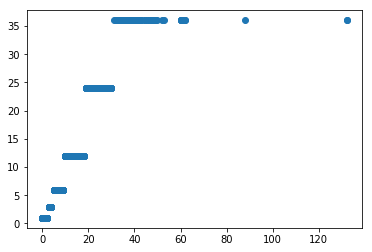

In [136]:
plt.scatter(df_A['months'], df_A['rebill_months'])

## Grouping the dataframe by rebill_months

In [137]:
# drop what we dont need
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

In [138]:
df_A.sample(10)

,curr,BU,period,amount,start_date_str,end_date_str,rebill_months
30979,EUR,Document Cloud,2015-08,-15.63,20150415,20160414,12.0
71216,GBP,Document Cloud,2017-10,-17.62,20170928,20180907,12.0
255524,USD,Print & Publishing,2018-05,2000.00,20180101,20181231,12.0
245941,USD,Document Cloud,2018-11,-28.63,20181026,20181123,1.0
66959,GBP,Document Cloud,2017-03,-16.11,20170130,20180125,12.0
222780,USD,Document Cloud,2018-06,-15.48,20180515,20190106,6.0
114582,USD,Document Cloud,2016-04,-206.31,20151022,20161021,12.0
163058,USD,Document Cloud,2017-06,-159.79,20170509,20180410,12.0
216285,USD,Document Cloud,2018-05,-89.36,20180413,20180902,6.0
81253,JPY,Creative,2017-09,296000.00,20170605,20180605,12.0


In [139]:
df_A['rebill_months'].value_counts()


12.0    107348
6.0      66637
1.0      57684
3.0      23258
24.0       692
36.0       546
Name: rebill_months, dtype: int64

In [140]:
#gb_A = df_A.groupby(['currency', 'BU', 'period'], as_index=False).sum()
# The code above adds the months as well. I do not want this.

In [141]:
#df_A.curr.value_counts()

In [142]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp = df_A.pivot_table('amount', ['curr', 'BU', 'period'], 'rebill_months')

In [143]:
temp.fillna(0)

rebill_months                            1.0           3.0            6.0   \
curr BU                 period                                               
AUD  Creative           2015-06   7410.857222  4.127300e+02       0.000000   
                        2015-08   7284.192982  2.570450e+02       0.000000   
                        2015-09   7122.768056  0.000000e+00       0.000000   
                        2015-10   6726.175517  1.281800e+02       0.000000   
                        2015-11   6896.387241  4.500000e+02       0.000000   
                        2015-12   6904.457222  3.000000e+02       0.000000   
                        2016-01    -11.984000  0.000000e+00       0.000000   
                        2016-02   6664.847500  2.890900e+02     412.730000   
                        2016-03   6219.013333  0.000000e+00       0.000000   
                        2016-05   6710.357931  1.281800e+02       0.000000   
                        2016-06   6174.654531  0.000000e+00     412.730000   
                        2016-07   6045.849310  1.281800e+02       0.000000   
                        2016-08   6202.775862  0.000000e+00       0.000000   
                        2016-09   5923.717778  0.000000e+00       0.000000   
                        2016-10   5948.620000  1.281800e+02       0.000000   
                        2016-11   5906.068276  0.000000e+00       0.000000   
                        2016-12  11460.629459  0.000000e+00     825.460000   
                        2017-02  -5889.663611  0.000000e+00    -412.730000   
                        2017-03   5834.551828  2.140900e+02       0.000000   
                        2017-04   6343.430000  1.281800e+02       0.000000   
                        2017-05   5615.712414  0.000000e+00       0.000000   
                        2017-06   5477.573684  0.000000e+00     412.730000   
                        2017-07    -12.990000  0.000000e+00       0.000000   
                        2017-08   5664.959828  1.281800e+02       0.000000   
                        2017-09   5736.605278  0.000000e+00       0.000000   
                        2017-10   5362.475161  1.281800e+02       0.000000   
                        2017-11   5882.615333  0.000000e+00       0.000000   
                        2017-12   5921.575405  0.000000e+00     412.730000   
                        2018-01   -597.660000  0.000000e+00       0.000000   
                        2018-02    -12.990000  0.000000e+00       0.000000   
...                                       ...           ...            ...   
USD  Print & Publishing 2017-01   1482.777368  0.000000e+00       0.000000   
                        2017-02   7798.284500 -3.683486e+04       0.000000   
                        2017-03  14890.670241  1.947836e+06       0.000000   
                        2017-04  10346.872667  5.770000e+01       0.000000   
                        2017-05   3534.248214  6.486607e+05       0.000000   
                        2017-06  45544.731628  1.137298e+06   33835.615000   
                        2017-07  10565.250357  1.525000e+04       0.000000   
                        2017-08  29010.683333  1.936700e+06       0.000000   
                        2017-09  94512.310000  1.473558e+05  142478.250000   
                        2017-10   2436.216000  1.875000e+04  125376.375000   
                        2017-11   9983.796452  1.480686e+06       0.000000   
                        2017-12  92513.191500  2.195211e+05  129027.113333   
                        2018-01   1321.538462  5.917000e+01       0.000000   
                        2018-02   9568.044848  0.000000e+00       0.000000   
                        2018-03  93621.795000  1.530189e+06   -2700.000000   
                        2018-04   7436.793103  0.000000e+00       0.000000   
                        2018-05  32862.976071  2.119800e+03       0.000000   
                        2018-06  81976.712222  2.158825e+06       0.000000   
                      

In [144]:
temp.rename(columns = {1.0: 'one_month', 3.0:'three_months',
                                 6.0:'six_months', 12.0:'twelve_months',
                                 24.0:'two_years', 36.0:'three_years'}, inplace=True)


In [145]:
temp.columns

Index(['one_month', 'three_months', 'six_months', 'twelve_months', 'two_years',
       'three_years'],
      dtype='object', name='rebill_months')

In [146]:
df.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,4992688.95,0.0,0.0,5828107.10,26443.20
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4115986.40,0.0,0.0,5011194.77,10399.50
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4365814.67,0.0,0.0,3989523.54,2316.62
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5665079.46,0.0,0.0,5841026.18,11534.00
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4646147.74,0.0,0.0,4444738.11,11802.30


In [147]:
temp.head()

rebill_months            one_month  three_months  six_months  twelve_months  \
curr BU       period                                                          
AUD  Creative 2015-06  7410.857222       412.730         NaN    4954.487778   
              2015-08  7284.192982       257.045         NaN    5985.608103   
              2015-09  7122.768056           NaN         NaN    5801.415278   
              2015-10  6726.175517       128.180         NaN    5229.060000   
              2015-11  6896.387241       450.000         NaN    5751.434138   

rebill_months           two_years  three_years  
curr BU       period                            
AUD  Creative 2015-06  608.377500          NaN  
              2015-08  648.305882          NaN  
              2015-09  741.312857          NaN  
              2015-10  597.380000          NaN  
              2015-11  672.630769          NaN

In [148]:
# now I need to combine the new dataframe (df_A) with df
df_merged = pd.merge(df, temp, how='outer', 
                 left_on=['curr', 'BU', 'period'],
                right_on=['curr', 'BU', 'period'])
df_merged = df_merged.fillna(value=0)

In [149]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,one_month,three_months,six_months,twelve_months,two_years,three_years
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,4992688.95,0.0,0.0,5828107.10,26443.20,7410.857222,412.730,0.0,4954.487778,608.377500,0.0
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4115986.40,0.0,0.0,5011194.77,10399.50,0.000000,0.000,0.0,0.000000,0.000000,0.0
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4365814.67,0.0,0.0,3989523.54,2316.62,7284.192982,257.045,0.0,5985.608103,648.305882,0.0
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5665079.46,0.0,0.0,5841026.18,11534.00,7122.768056,0.000,0.0,5801.415278,741.312857,0.0
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4646147.74,0.0,0.0,4444738.11,11802.30,6726.175517,128.180,0.0,5229.060000,597.380000,0.0


In [ ]:
#df_merged.curr.value_counts()

In [150]:
df_merged['deferred_1M'] = df_merged['deferred_1M']+df_merged['one_month']
df_merged.drop(labels=['one_month'], axis=1, inplace=True)


In [151]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,three_months,six_months,twelve_months,two_years,three_years
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,0.0,0.0,5828107.10,26443.20,412.730,0.0,4954.487778,608.377500,0.0
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.0,0.0,5011194.77,10399.50,0.000,0.0,0.000000,0.000000,0.0
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,0.0,0.0,3989523.54,2316.62,257.045,0.0,5985.608103,648.305882,0.0
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.0,0.0,5841026.18,11534.00,0.000,0.0,5801.415278,741.312857,0.0
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,0.0,0.0,4444738.11,11802.30,128.180,0.0,5229.060000,597.380000,0.0


In [152]:
df_merged['deferred_3M'] = df_merged['deferred_3M']+df_merged['three_months']
df_merged.drop(labels=['three_months'], axis=1, inplace=True)

df_merged['deferred_6M'] = df_merged['deferred_6M']+df_merged['six_months']
df_merged.drop(labels=['six_months'], axis=1, inplace=True)

df_merged['deferred_1Y'] = df_merged['deferred_1Y']+df_merged['twelve_months']
df_merged.drop(labels=['twelve_months'], axis=1, inplace=True)

df_merged['deferred_2Y'] = df_merged['deferred_2Y']+df_merged['two_years']
df_merged.drop(labels=['two_years'], axis=1, inplace=True)

df_merged['deferred_3Y'] = df_merged['deferred_3Y']+df_merged['three_years']
df_merged.drop(labels=['three_years'], axis=1, inplace=True)


In [153]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.0,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,5.011195e+06,10399.500000
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,3.995509e+06,2964.925882
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.000,0.0,5.846828e+06,12275.312857
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,128.180,0.0,4.449967e+06,12399.680000


In [154]:
df_merged.columns

Index(['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
       'deferred_3Y', 'deferred_1M', 'deferred_3M', 'deferred_6M',
       'deferred_1Y', 'deferred_2Y'],
      dtype='object')

In [155]:
df_merged.head()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.0,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,5.011195e+06,10399.500000
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,3.995509e+06,2964.925882
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.000,0.0,5.846828e+06,12275.312857
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,128.180,0.0,4.449967e+06,12399.680000


In [156]:
df_merged.tail()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
2810,NOK,Other Solutions,2018-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32891.96,0.0
2811,SEK,Other Solutions,2015-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28800.00,0.0
2812,SEK,Other Solutions,2015-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23580.00,0.0
2813,SEK,Other Solutions,2016-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21600.00,0.0
2814,SEK,Other Solutions,2017-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33934.80,0.0


In [157]:
df_merged['deferred_3M'].describe()

count    2.815000e+03
mean     7.872754e+05
std      3.851819e+06
min     -1.001754e+06
25%      0.000000e+00
50%      0.000000e+00
75%      2.945450e+02
max      4.392479e+07
Name: deferred_3M, dtype: float64

In [ ]:
#df_merged.curr.value_counts()

# Loading Currency Data & Period Data

## Currency Map

The currency map is a list of countries (as an index) and the document currency that is the primary billing currency of that country. It is stored as a dataframe with an index ['Country'] and the column ['Currency']

In [158]:
curr_map = pd.read_excel('../data/Data_2019_P06/currency_map.xlsx', 'curr_map')
curr_map['Country'] = curr_map['Country'].map(lambda x: str(x)[:-4])
curr_map.set_index('Country', inplace=True)
curr_map

,Currency
Country,
Aus and New Zealand,AUD
Benelux,EUR
Brazil,USD
Canada,USD
China,USD
Eastern Europe,EUR
France,EUR
Germany,EUR
Hong Kong,USD


## FX Forward Rates
There are three forward rate variables created in this section of code and all are converted from normal currency quotes to indirect quotes such that any conversion back to USD will simply be the exchange rate multiplied by the document currency.

df_FX_rates - is a dataframe. The index to this dataframe is the document currency. The columns are the spot exchange rate and monthly forward exchange rates going out one year. 

FX_rates - is a numpy array containing the same data as the dataframe with the exception of the DC index. 
    rows - number of document currencies
    columns - Spot rate, 1M fwd rate, 2M fwd rate, ., ., ..... 12M fwd rate

list_FX_rates - a list containing the document currency corresponding with the FX_rates array.

In [159]:
def load_forward_rates():
    df_FX_rates = pd.read_excel('../data/Data_2019_P06/FX_data.xlsx', 'to_matlab')
    # converting vols to decimals (bloomberg downloads problem with rates)
    df_FX_rates['VOL_3M'] = df_FX_rates['VOL_3M']/100
    df_FX_rates['VOL_6M'] = df_FX_rates['VOL_6M']/100
    df_FX_rates['VOL_9M'] = df_FX_rates['VOL_9M']/100
    df_FX_rates['VOL_1Y'] = df_FX_rates['VOL_1Y']/100
    
    # invert indirect interest rates so that all currencies are in same format
    to_invert = df_FX_rates['Ticker'].str.slice(0,3).str.contains('USD')
    for index, row in df_FX_rates.iterrows():
         if to_invert.iloc[index] == True:
            df_FX_rates['Spot'].loc[index] = 1/row['Spot']
            df_FX_rates['FWD_3M'].loc[index]  = 1/row['FWD_3M']
            df_FX_rates['FWD_6M'].loc[index]  = 1/row['FWD_6M']
            df_FX_rates['FWD_9M'].loc[index]  = 1/row['FWD_9M']
            df_FX_rates['FWD_1Y'].loc[index]  = 1/row['FWD_1Y']
            
    # Interpolating the forward rates
    df_FX_rates['FWD_1M'] = df_FX_rates['Spot']* (2/3) + df_FX_rates['FWD_3M']*(1/3)
    df_FX_rates['FWD_2M'] = df_FX_rates['Spot']* (1/3) + df_FX_rates['FWD_3M']*(2/3)

    df_FX_rates['FWD_4M'] = df_FX_rates['FWD_3M']* (2/3) + df_FX_rates['FWD_6M']*(1/3)
    df_FX_rates['FWD_5M'] = df_FX_rates['FWD_3M']* (1/3) + df_FX_rates['FWD_6M']*(2/3)

    df_FX_rates['FWD_7M'] = df_FX_rates['FWD_6M']* (2/3) + df_FX_rates['FWD_9M']*(1/3)
    df_FX_rates['FWD_8M'] = df_FX_rates['FWD_6M']* (1/3) + df_FX_rates['FWD_9M']*(2/3)

    df_FX_rates['FWD_10M'] = df_FX_rates['FWD_9M']* (2/3) + df_FX_rates['FWD_1Y']*(1/3)
    df_FX_rates['FWD_11M'] = df_FX_rates['FWD_9M']* (1/3) + df_FX_rates['FWD_1Y']*(2/3)

    
    df_FX_rates.drop(['Ticker', 'VOL_3M', 'VOL_6M', 'VOL_9M', 'VOL_1Y'], axis=1, inplace=True)
    df_FX_rates.set_index('DC', inplace=True)
    
    sorted_columns = ['Spot', 'FWD_1M', 'FWD_2M','FWD_3M',
           'FWD_4M','FWD_5M','FWD_6M',
           'FWD_7M','FWD_8M','FWD_9M',
           'FWD_10M','FWD_11M','FWD_1Y']
    df_FX_rates = df_FX_rates[sorted_columns]
    
    list_FX_rates = df_FX_rates.index.to_list()
    FX_rates = df_FX_rates.to_numpy()
    
    return df_FX_rates, FX_rates, list_FX_rates

In [160]:
df_FX_rates, FX_rates, list_FX_rates = load_forward_rates()

C:\Users\davsmith\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## FX Plan Rates 

This section pulls in plan forward rates in order to back into the document currency billings. (FP&A provides net new billings forecasts in terms of USD by country. The currency map is used to determine the primary currency of these billings and the forward rates are used to back these USD billings into document currency.)

book_FX_rates is a dataframe with an index['Currency'] and one column ['forward']. 

NOTE: The forward rates are all in terms direct.

In [161]:
book_FX_rates = pd.read_excel('../data/Data_2019_P06/FX_forward_rates.xlsx', sheet_name='forward_data', 
                        header=1,   index_col=1)

# dropping columns that are completely blank
book_FX_rates.dropna(how='all', axis='columns', inplace=True)

# first rename one of the unnamed columns that you intend to keep
# then delete the other unnamed columns
book_FX_rates.rename( columns={'Unnamed: 2': 'Currency', 'FWD REF':'forward'}, inplace=True)
                               
book_FX_rates.drop(['Pricing Date', 91, 'PX ASK', '% Change', 'SPOT', 'FWD'], axis=1, inplace=True)
book_FX_rates.set_index('Currency', inplace=True)
book_FX_rates

,forward
Currency,
AED,3.673964
AUD,1.439320
BBD,2.013300
BMD,1.000000
BRL,3.954754
CAD,1.349750
CHF,0.993608
CLP,711.160000
COP,3399.421300


## Period Weeks
This section loads an excel file that contains the number of weeks in a period. 

Note: In the future this should be changed to be pulled directly from the ADOBE_FINANCIAL_CALENDAR datbase.

In [162]:
df_period_weeks = pd.read_excel('../data/Data_2019_P06/Period_weeks.xlsx', sheet_name='period_weeks')
df_period_weeks.set_index('Period', inplace=True)
df_period_weeks.sample(10)

,Weeks
Period,
2017-02,4
2024-03,5
2021-04,4
2020-10,4
2019-01,4
2020-01,4
2024-01,4
2015-08,4
2017-04,4


In [ ]:
whos

In [163]:
df_merged.head(20)

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.00,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.00,5.011195e+06,10399.500000
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.00,3.995509e+06,2964.925882
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.000,0.00,5.846828e+06,12275.312857
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,128.180,0.00,4.449967e+06,12399.680000
5,AUD,Creative,2015-11,361723.22,0.0,0.0,0.0,5.084470e+06,450.000,0.00,3.487610e+06,33072.130769
6,AUD,Creative,2015-12,276178.28,0.0,0.0,0.0,6.508168e+06,300.000,0.00,1.169531e+07,21287.755625
7,AUD,Creative,2016-01,270306.21,0.0,0.0,0.0,6.703052e+06,0.000,0.00,3.722175e+06,37020.000000
8,AUD,Creative,2016-02,116996.45,0.0,0.0,0.0,5.470467e+06,289.090,412.73,4.163052e+06,7607.473684
9,AUD,Creative,2016-03,235382.84,0.0,0.0,0.0,7.497134e+06,0.000,0.00,5.749068e+06,37216.813636


# Messing with the forecast file

In [ ]:
passed_fcst_length = fcst_length;
temp_fcst_length = 12;

last_period = key.fcst_last_period;
'''
output is a dataframe fcst.bill.deferred

fcst.bill.service
fcst.bill.recognized
fcst.bill.DC


each is 4 dimensional

    x - forecast length (time in months)
    y - length of the deferred rebill rules
    z - currency
    aa - bu
    
Just make this one big ass dataframe

Rows index = time

columns ['Currency']
        ['BU']
        ['recognized']
        ['service']
        ['deferred_1M', 'deferred_2M', ..... 'deferred_3M']
        
'''

In [164]:
df_fcst = pd.DataFrame(columns=['curr', 'BU', 'period', 'recognized', 'service', 'deferred_B',
                                'deferred_1M','deferred_3M','deferred_6M','deferred_1Y',
                                'deferred_2Y','deferred_3Y'])

In [165]:
df_fcst

,curr,BU,period,recognized,service,deferred_B,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y,deferred_3Y


In [166]:
df_merged.tail()

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
2810,NOK,Other Solutions,2018-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32891.96,0.0
2811,SEK,Other Solutions,2015-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28800.00,0.0
2812,SEK,Other Solutions,2015-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23580.00,0.0
2813,SEK,Other Solutions,2016-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21600.00,0.0
2814,SEK,Other Solutions,2017-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33934.80,0.0


First attempt
create unique list of BUs and Currencies
loop through these and then copy over recognized and service billings and move through the columns indexing the others

A. Create period list

In [167]:
per = df_merged['period'].unique()
per.sort()
last_period = per[-1]

In [168]:
def build_fcst_periods(last_period, numb_periods):
    this_year = last_period[0:4]
    int_year = int(this_year)
    
    this_month = last_period[-2:]
    int_month = int(this_month)
    list_periods =[]
    
    for per in range(num_periods):
        int_month = int_month + 1
        if int_month > 12:
            int_month = 1
            int_year += 1
        
        if int_month < 10:
            temp_month_str = '0'+str(int_month)
        else:
            temp_month_str = str(int_month)
            
        list_periods.append(str(int_year)+'-'+temp_month_str)
    return list_periods
    

In [169]:
num_periods = 12
list_periods= build_fcst_periods(last_period, num_periods)
list_periods

['2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06']

In [170]:
# creating unique lists of currency and BU
list_curr = df_merged['curr'].unique()
print('list_curr: ', list_curr)

list_BU = df_merged['BU'].unique()
print('list_BU: ', list_BU)


list_curr:  ['AUD' 'BRL' 'CAD' 'CHF' 'DKK' 'EUR' 'GBP' 'HKD' 'JPY' 'KRW' 'NOK' 'NZD'
 'RUB' 'SEK' 'SGD' 'USD' 'ARS' 'CLP' 'COP' 'PEN' 'MXP']
list_BU:  ['Creative' 'Document Cloud' 'Experience Cloud' 'LiveCycle'
 'Other Solutions' 'Print & Publishing']


In [ ]:
# creating some sort of massive loop to start


    
for this_curr in list_curr:
        
    for this_BU in list_BU:
        
        curr_array = []
        BU_array = []
        
        for period in list_periods:
    
            curr_array.append(this_curr)
            BU_array.append(this_BU)
        
        

        #print(period, ' ', curr, ' ', BU)
            this_df = df_merged[(df_merged['curr']==this_curr) & (df_merged['BU']==this_BU)]
            
            # periods = list_periods
            deferred_3Y = this_df['deferred_3Y'].iloc[-36:-24].to_numpy()
            deferred_2Y = this_df['deferred_2Y'].iloc[-24:-12].to_numpy()
            deferred_1Y = this_df['deferred_1Y'].iloc[-12:].to_numpy()
           
            deferred_6M_p1 = this_df['deferred_6M'].iloc[-6:].to_numpy()           
            deferred_6M = np.concatenate((deferred_6M_p1, deferred_6M_p1),axis=0)
            
            deferred_3M_p1 = this_df['deferred_3M'].iloc[-3:].to_numpy()
            deferred_3M_half = np.concatenate((deferred_3M_p1,deferred_3M_p1), axis=0)
            deferred_3M = np.concatenate((deferred_3M_half,deferred_3M_half), axis=0)
            
            # 1 Month
            
            # recognized - use average of last 12 months
            v_recognized = this_df['recognized'].iloc[-12:].to_numpy()
            avg_recognized = np.mean(v_recognized)
            recognized = np.ones(12)*avg_recognized
            
            # service - use average of last 12 months
            v_svc = this_df['service'].iloc[-12:].to_numpy()
            avg_svc = np.mean(v_svc)
            service = np.ones(12)*avg_svc
            
            # deferred B
            v_def_B = this_df['deferred_B'].iloc[-12:].to_numpy()
            avg_def_B = np.mean(v_def_B)
            deferred_B = np.ones(12)*avg_def_B
            
            # need to take the 1M deferred and adjust for weekly average then forecast a simple linear regression
            # divide by period weeks
            # forecast
            # 
            def_1M = this_df['deferred_1M'].to_numpy()
            def_1M = def_1M.reshape(-1,1)
            
            
            
            #adjust for period weeks
            x = np.arange(len(def_1M))
            x = x.reshape(-1,1)

            all_weeks = df_period_weeks['Weeks'].to_numpy()
            all_weeks = all_weeks.reshape(-1,1)
            weeks = all_weeks[0:len(x)]
            weeks = weeks.reshape(-1,1)
            fcst_weeks = all_weeks[len(x):len(x)+12]
            fcst_weeks = fcst_weeks.reshape(-1,1)
            
            def_1M_wkly= np.true_divide(def_1M, weeks)
            
            x_fcst = np.arange(len(def_1M_wkly), len(def_1M)+12)
            x_fcst = x_fcst.reshape(-1,1)
            model = LinearRegression()
            model.fit(x, def_1M)
            def_1M_fcst_wkly = model.predict(x_fcst)
            
            def_1M_fcst = def_1M_fcst_wkly * fcst_weeks
            #adjust for the period weeks
            
            
            

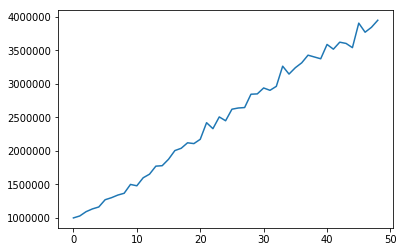

In [318]:
x = np.arange(len(def_1M))
x = x.reshape(-1,1)

all_weeks = df_period_weeks['Weeks'].to_numpy()
all_weeks = all_weeks.reshape(-1,1)
weeks = all_weeks[0:len(x)]
weeks = weeks.reshape(-1,1)
fcst_weeks = all_weeks[len(x):len(x)+12]
fcst_weeks = fcst_weeks.reshape(-1,1)

def_1M_wkly= np.true_divide(def_1M, weeks)

x_fcst = np.arange(len(def_1M_wkly), len(def_1M)+12)
x_fcst = x_fcst.reshape(-1,1)
model = LinearRegression()
model.fit(x, def_1M)
def_1M_fcst_wkly = model.predict(x_fcst)

def_1M_fcst = def_1M_fcst_wkly * fcst_weeks
#adjust for the period weeks

plt.plot(x, def_1M)

array([[7.09647323e+07],
       [7.20744001e+07],
       [9.14800850e+07],
       [7.42937359e+07],
       [7.54034037e+07],
       [9.56413395e+07],
       [7.76227395e+07],
       [7.87324073e+07],
       [9.98025940e+07],
       [8.09517431e+07],
       [8.20614109e+07],
       [1.03963848e+08]])

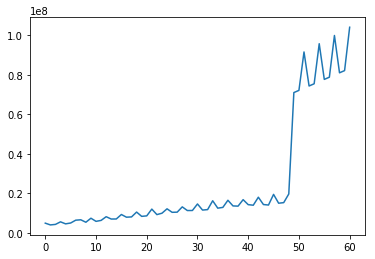

In [326]:
tempX = np.concatenate((x, x_fcst), axis=0)
tempY = np.concatenate((def_1M, def_1M_fcst), axis=0)
plt.plot(tempX, tempY)

In [311]:
#adjust for period weeks
x = np.arange(len(def_1M))
x = x.reshape(-1,1)

weeks = df_period_weeks['Weeks'].to_numpy()
weeks.reshape(-1,1)
weeks = weeks[0:len(x)]

weeks = weeks.reshape(-1,1)

print('weeks shape: ', weeks.shape)
print('def_1M shape: ', def_1M.shape)
def_1M_wkly= np.true_divide(def_1M, weeks)
def_1M_wkly

weeks shape:  (49, 1)
def_1M shape:  (49, 1)


array([[1000019.96144444],
       [1028996.6       ],
       [1093274.71574561],
       [1134440.44561111],
       [1163218.47887931],
       [1271117.59431034],
       [1301633.61344444],
       [1340610.3332    ],
       [1367616.804375  ],
       [1499426.80466667],
       [1479296.67      ],
       [1598727.71448276],
       [1652422.71290625],
       [1772179.83482759],
       [1779018.84146552],
       [1874870.37755556],
       [2004559.27      ],
       [2038924.81956897],
       [2120599.30589189],
       [2108726.6125    ],
       [2172608.11659722],
       [2420383.53236559],
       [2331414.6275    ],
       [2506518.63310345],
       [2449402.02873684],
       [2621629.26      ],
       [2639635.1449569 ],
       [2646334.65905556],
       [2845141.02879032],
       [2850138.85883333],
       [2938443.33908108],
       [2903405.3675    ],
       [2962715.31      ],
       [3263701.7583617 ],
       [3145809.72765152],
       [3240921.74742188],
       [3313151.83708108],
 

In [313]:
x_fcst = np.arange(len(def_1M_wkly), len(def_1M)+12)
x_fcst = x_fcst.reshape(-1,1)
model = LinearRegression()
model.fit(x, def_1M)
def_1M_fcst_wkly = model.predict(x_fcst)

def_1M_fcst =def_1M_fcst_wkly * weeks


ValueError: operands could not be broadcast together with shapes (12,1) (49,1) 

In [297]:
def_1M_wkly


array([[1000019.96144444, 1250024.95180556, 1250024.95180556, ...,
        1250024.95180556, 1250024.95180556, 1000019.96144444],
       [ 823197.28      , 1028996.6       , 1028996.6       , ...,
        1028996.6       , 1028996.6       ,  823197.28      ],
       [ 874619.77259649, 1093274.71574561, 1093274.71574561, ...,
        1093274.71574561, 1093274.71574561,  874619.77259649],
       ...,
       [3016000.30889655, 3770000.38612069, 3770000.38612069, ...,
        3770000.38612069, 3770000.38612069, 3016000.30889655],
       [3074450.79565517, 3843063.49456897, 3843063.49456897, ...,
        3843063.49456897, 3843063.49456897, 3074450.79565517],
       [3948719.61538889, 4935899.51923611, 4935899.51923611, ...,
        4935899.51923611, 4935899.51923611, 3948719.61538889]])

In [283]:
def_1M = this_df['deferred_1M'].to_numpy()
def_1M = def_1M.reshape(-1,1)
x = np.arange(len(def_1M))
x = x.reshape(-1,1)
x_fcst = np.arange(len(def_1M),len(def_1M)+12)
x_fcst = x_fcst.reshape(-1,1)
#print(x)
#print(x_fcst)
model = LinearRegression()
model.fit(x, def_1M)
def_1M_fcst = model.predict(x_fcst)
print(def_1M)
print(def_1M_fcst)

[[ 5000099.80722222]
 [ 4115986.4       ]
 [ 4373098.86298246]
 [ 5672202.22805556]
 [ 4652873.91551724]
 [ 5084470.37724138]
 [ 6508168.06722222]
 [ 6703051.666     ]
 [ 5470467.2175    ]
 [ 7497134.02333333]
 [ 5917186.68      ]
 [ 6394910.85793103]
 [ 8262113.56453125]
 [ 7088719.33931035]
 [ 7116075.36586207]
 [ 9374351.88777778]
 [ 8018237.08      ]
 [ 8155699.27827586]
 [10602996.52945946]
 [ 8434906.45      ]
 [ 8690432.46638889]
 [12101917.66182796]
 [ 9325658.51      ]
 [10026074.5324138 ]
 [12247010.14368421]
 [10486517.04      ]
 [10558540.57982759]
 [13231673.29527778]
 [11380564.11516129]
 [11400555.43533333]
 [14692216.69540541]
 [11613621.47      ]
 [11850861.24      ]
 [16318508.79180851]
 [12583238.91060606]
 [12963686.9896875 ]
 [16565759.18540541]
 [13710853.04551724]
 [13602829.81133333]
 [16869368.04777778]
 [14350435.01935484]
 [14068552.16517241]
 [18107273.69833333]
 [14410854.18      ]
 [14159556.7945614 ]
 [19527023.16055555]
 [15080001.54448276]
 [15372253.97

In [265]:
x.shape

(49,)

In [246]:
deferred_3M_p1 = this_df['deferred_3M'].iloc[-3:].to_numpy()
deferred_3M_half = np.concatenate((deferred_3M_p1,deferred_3M_p1), axis=0)
deferred_3M = np.concatenate((deferred_3M_half,deferred_3M_half), axis=0)
print(deferred_3M)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [248]:
v_recognized = this_df['recognized'].iloc[-12:].to_numpy()
avg_recognized = np.mean(v_recognized)
recognized = np.ones(12)*avg_recognized


[195203.02 203324.92 207983.07 176830.19 108316.18 278448.03 110846.98
 216462.6  164031.92 121348.81 100273.45 145603.84]


In [243]:
deferred_6M_p1 = this_df['deferred_6M'].iloc[-6:].to_numpy()           

print(deferred_6M_p1)
#np.reshape(deferred_6M_p1, (-1,1))

#print(deferred_6M_p1)
deferred_6M = np.concatenate((deferred_6M_p1, deferred_6M_p1),axis=0)
print(deferred_6M)
#deferred_6M.reset_index(inplace=True)


[  0.   0.   0. 999.   0.   0.]
[  0.   0.   0. 999.   0.   0.   0.   0.   0. 999.   0.   0.]


In [244]:
deferred_3Y = this_df['deferred_3Y'].iloc[-36:-24].to_numpy()
deferred_3Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [241]:
#this_df['deferred_6M']

In [171]:
this_curr = list_curr[0]
this_BU = list_BU[0]
print('this_year: ', this_curr)
print('this_BU: ', this_BU)

this_year:  AUD
this_BU:  Creative


In [192]:
this_df = df_merged[(df_merged['curr']==this_curr) & (df_merged['BU']==this_BU)]

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
0,AUD,Creative,2015-06,490156.86,0.0,0.0,0.0,5.000100e+06,412.730,0.0,5.833062e+06,27051.577500
1,AUD,Creative,2015-07,235045.62,0.0,0.0,0.0,4.115986e+06,0.000,0.0,5.011195e+06,10399.500000
2,AUD,Creative,2015-08,284334.70,0.0,0.0,0.0,4.373099e+06,257.045,0.0,3.995509e+06,2964.925882
3,AUD,Creative,2015-09,369648.88,0.0,0.0,0.0,5.672202e+06,0.000,0.0,5.846828e+06,12275.312857
4,AUD,Creative,2015-10,287292.48,0.0,0.0,0.0,4.652874e+06,128.180,0.0,4.449967e+06,12399.680000


In [188]:
deferred_2Y = this_df['deferred_2Y'].iloc[-24:13]
deferred_2Y

Series([], Name: deferred_2Y, dtype: float64)

In [202]:
this_df.iloc[-12:]

,curr,BU,period,recognized,service,deferred_B,deferred_3Y,deferred_1M,deferred_3M,deferred_6M,deferred_1Y,deferred_2Y
37,AUD,Creative,2018-07,195203.02,0.0,0.0,0.0,1.371085e+07,128.18,0.0,1.046606e+07,10888.83
38,AUD,Creative,2018-08,203324.92,0.0,0.0,0.0,1.360283e+07,0.00,0.0,8.389952e+06,1103.88
39,AUD,Creative,2018-09,207983.07,0.0,0.0,0.0,1.686937e+07,0.00,0.0,1.315832e+07,7723.23
40,AUD,Creative,2018-10,176830.19,0.0,0.0,0.0,1.435044e+07,128.18,0.0,7.880099e+06,40.00
41,AUD,Creative,2018-11,108316.18,0.0,0.0,0.0,1.406855e+07,0.00,0.0,6.713268e+06,4047.56
42,AUD,Creative,2018-12,278448.03,0.0,0.0,0.0,1.810727e+07,0.00,0.0,2.223955e+07,518.00
43,AUD,Creative,2019-01,110846.98,0.0,0.0,0.0,1.441085e+07,0.00,0.0,8.864629e+06,34.00
44,AUD,Creative,2019-02,216462.60,0.0,0.0,0.0,1.415956e+07,0.00,0.0,7.382928e+06,0.00
45,AUD,Creative,2019-03,164031.92,0.0,0.0,0.0,1.952702e+07,0.00,0.0,1.307520e+07,12.00
46,AUD,Creative,2019-04,121348.81,0.0,0.0,0.0,1.508000e+07,0.00,0.0,8.961752e+06,6347.31


In [ ]:
# how do I do this?
# one by one???? Do I create the dataframes individually and then append?

curr_array = []
BU_array = []
period_array = list_periods
for per in list_periods:
    curr_array.append(this_curr)
    BU_array.append(this_BU)

print(curr_array)
print(BU_array)



In [ ]:
df_fcst.columns


In [ ]:
len(df_merged)

In [ ]:
df_temp = df_merged.drop_duplicates()

In [ ]:
len(df_temp)

In [ ]:
df_merged.iloc[0:50]

In [271]:
x = df_period_weeks['Weeks'].to_numpy()

In [276]:
df_period_weeks.iloc[list_periods]

ValueError: invalid literal for int() with base 10: '2019-07'

In [277]:
list_periods

['2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06']

In [279]:
df_period_weeks

,Weeks
Period,
2015-06,5
2015-07,4
2015-08,4
2015-09,5
2015-10,4
2015-11,4
2015-12,5
2016-01,5
2016-02,4


array(['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11',
       '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05',
       '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11',
       '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05',
       '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
       '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11',
       '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05',
       '2019-06', '2015-04', '2015-05'], dtype=object)